Welcome to the Custom ViT Colab! This notebook provides a hands-on implementation of the [proposed model](https://), showcasing its training, evaluation, and ensembling capabilities.

#PIP install

In [ ]:
%%capture
!pip install torch torchvision timm tqdm fvcore matplotlib seaborn torchmetrics

In [ ]:
%%capture
!pip install pytorch-ood

In [ ]:
%%capture
!pip install torchattacks

#Import Libraries

In [ ]:
%%capture
import argparse
import json
import math
import os
from collections import defaultdict
from copy import deepcopy
from itertools import chain
from typing import Union
from torchmetrics.functional.classification import multiclass_calibration_error
import numpy as np
import timm
import torch
import torchvision
import tqdm
from matplotlib import pyplot as plt
from timm.models import VisionTransformer, checkpoint_seq
from timm.models.vision_transformer import Block
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from math import cos, pi
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from pytorch_ood.dataset.img import TinyImageNetCrop
from pytorch_ood.utils import ToUnknown
from pytorch_ood.utils import OODMetrics
from pytorch_ood.detector import EnergyBased
import torchattacks

In [ ]:
import pandas as pd
import contextlib
import os

from pytorch_ood.dataset.img import (
    LSUNCrop,
    LSUNResize,
    Textures,
    TinyImageNetCrop,
    TinyImageNetResize,
    Places365,
    TinyImageNet
)
from pytorch_ood.detector import (
     ODIN,
     EnergyBased,
     Entropy,
     KLMatching,
     Mahalanobis,
     MaxLogit,
     MaxSoftmax,
     ViM,
     RMD,
     DICE,
     SHE,
 )

#Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Custom ViT class


The core of the project is the Custom ViT class. Note that to increase the number of subnetwork (i.e. additional tokens), it's needed to change the `num_tokens` parameter in the `__init__` function.




In [ ]:
class CustomVit(nn.Module):
    def __init__(self, model: VisionTransformer, num_tokens=3, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._model = model

        self.num_tokens = num_tokens

        #Initialize up to num_tokens additional tokens
        self.additional_tokens = nn.ParameterList([
            nn.Parameter(torch.randn_like(self._model.cls_token) * 0.02)
            for _ in range(num_tokens)
        ])


    # Embeddings positioning with dynamic token generation
    def _pos_embed(self, x, token_index):

        x = self._model._pos_embed(x)

        embedding = self.additional_tokens[token_index].expand(x.shape[0], -1, -1)  # Expand to match batch size

        # Concatenation
        x = torch.cat((x, embedding), 1)

        return x

    def __getattr__(self, item):
        try:
            return super().__getattr__(item)
        except AttributeError:
            return getattr(self._model, item)



    def forward_features(self, x: torch.Tensor, token_index: int) -> torch.Tensor:
        x = self.patch_embed(x)

        x = self._pos_embed(x, token_index)

        x = self.patch_drop(x)

        x = self.norm_pre(x)

        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x)
        else:
            prev_mask = None
            for b in self.blocks:
                prev_mask = None
                x = b(x)
        x = self.norm(x)

        return x

    def forward(self, x, token_index):

        # Token index must be given
        if token_index >= self.num_tokens or token_index < 0:
            raise ValueError(f"token_index must be between 0 and {self.num_tokens - 1}")

        x = self.forward_features(x, token_index)
        x = self.forward_head(x)


        return x

#Data preparation

Retrieval and transformation for Imagenette.

In [ ]:
%%capture
!mkdir -p ./data/imagenette
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -O ./data/imagenette/imagenette2-160.tgz
!tar -xvzf ./data/imagenette/imagenette2-160.tgz -C ./data/imagenette --strip-components=1


In [ ]:
train_transform = T.Compose([

    T.RandAugment(num_ops=2, magnitude=9),
    T.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=0),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

test_transform = T.Compose([

    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])

trainset = torchvision.datasets.ImageFolder(root='./data/imagenette/train', transform=train_transform)
testset = torchvision.datasets.ImageFolder(root='./data/imagenette/val', transform=test_transform)


#Training

Training loops for the different kinds of ensembles.

## Training Custom ViT (Average Ensemble)

In [ ]:
BATCH_SIZE = 128     # IF TRAINING IN COLAB, USE BATCH_SIZE OF 64 FOR 5 SUBNETWORKS OR MORE
EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit = timm.create_model('deit_tiny_patch16_224.fb_in1k', pretrained=True)

In [ ]:
vit = CustomVit(vit)

vit.to(device)

print(f"ViT with {vit.num_tokens} tokens created")

In [ ]:
opt_custom = Adam(chain(vit.parameters()), lr=1e-4)
scheduler_custom = torch.optim.lr_scheduler.CosineAnnealingLR(opt_custom, T_max=EPOCHS, eta_min=1e-6)

#Keeping track of losses and KL divergence
ensemble_losses_per_epoch = []
kl_per_epoch = []
lambda_kl = 0.3


for epoch in tqdm(range(EPOCHS), desc="Epochs", leave=True):
    vit.train()
    epoch_ensemble_loss = 0.0
    epoch_kl_div= 0.0

    print(f"Lambda for Epoch {epoch+1}: {lambda_kl:.4f}")

    for x, y in tqdm(DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True), desc="Batches", leave=False):
        x, y = x.to(device), y.to(device)

        logits_list = []
        for i in range(vit.num_tokens):  # Iterate over the subnetworks
          logits = vit(x, token_index=i)
          logits_list.append(logits)

        # Average the logits and compute the CE loss
        ensemble_logits = torch.stack(logits_list, dim=0).mean(dim=0)
        ensemble_loss_mean = F.cross_entropy(ensemble_logits, y)

        # Compute the KL divergence between each logits and the average ensemble logits (to avoid pairwise KL)

        kl_div = 0
        for logits in logits_list:
            log_probs = F.log_softmax(logits, dim=-1)
            probs = F.softmax(ensemble_logits, dim=-1) + 1e-8  # for numerical stability
            kl_div += F.kl_div(log_probs, probs, reduction='batchmean')

        kl_div /= len(logits_list)

        loss = ensemble_loss_mean - kl_div*lambda_kl

        epoch_ensemble_loss += (ensemble_loss_mean).item()
        epoch_kl_div += (kl_div).item()

        opt_custom.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vit.parameters(), 1)
        opt_custom.step()

    scheduler_custom.step()

    # Avgs for print
    avg_ensemble_loss = epoch_ensemble_loss / len(DataLoader(trainset))
    avg_kl_div = epoch_kl_div / len(DataLoader(trainset))

    # Lists for graphs
    ensemble_losses_per_epoch.append(avg_ensemble_loss)
    kl_per_epoch.append(avg_kl_div)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Ensemble Loss (mean): {avg_ensemble_loss:.4f}")
    print(f"KL divergence (mean): {avg_kl_div:.4f}\n")


    if epoch==9:
      torch.save({
          'epoch': epoch + 1,
          'model_state_dict': vit.state_dict(),
          'optimizer_state_dict': opt_custom.state_dict(),
          'scheduler_state_dict': scheduler_custom.state_dict(),
          'ensemble_losses': ensemble_losses_per_epoch,
          'kl_div':kl_per_epoch,
      },f'/PATH_TO_SAVE_LAST_EPOCH_{epoch+1}.pth')


##Training Custom ViT (Ensemble by partitioning)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit = timm.create_model('deit_tiny_patch16_224.fb_in1k', pretrained=True)

In [ ]:
vit = CustomVit(vit)

vit.to(device)

print(f"ViT with {vit.num_tokens} tokens created")

In [ ]:
# Define the size of each subset dividing equally for each subnetwork

tokens = 3      #CHANGE THIS ACCORDING TO THE NUMBER OF SUBNETWORKS INSTANTIATED

subset_sizes = [int(len(trainset) / tokens)] * tokens
subset_sizes[-1] = len(trainset) - sum(subset_sizes[:-1])

subsets = random_split(trainset, subset_sizes)

subsets_loaders = [DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True) for subset in subsets]

print(f"Created {len(subsets_loaders)} subsets for {vit.num_tokens} subnetworks")

In [ ]:
opt_custom = Adam(chain(vit.parameters()), lr=1e-4)
scheduler_custom = torch.optim.lr_scheduler.CosineAnnealingLR(opt_custom, T_max=EPOCHS, eta_min=1e-6)

#Keeping track of the loss
total_losses_per_epoch = []

for epoch in tqdm(range(EPOCHS), desc="Epochs", leave=True):
    vit.train()
    epoch_total_loss = 0.0
    total_batches = 0

    for i, loader in enumerate(subsets_loaders):
        for x, y in tqdm(loader, desc=f"Training Subnetwork {i+1}", leave=False):
            x, y = x.to(device), y.to(device)

            # Forward pass through the specific subnetwork
            logits = vit(x, token_index=i)

            subnetwork_loss = F.cross_entropy(logits, y)

            opt_custom.zero_grad()
            subnetwork_loss.backward()
            torch.nn.utils.clip_grad_norm_(vit.parameters(), 1)
            opt_custom.step()

            epoch_total_loss += subnetwork_loss.item()
            total_batches += 1

    scheduler_custom.step()

    avg_loss = epoch_total_loss / (len(trainset) * vit.num_tokens / BATCH_SIZE)
    total_losses_per_epoch.append(avg_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Ensemble Loss (mean): {avg_loss:.4f}")

    if epoch==9:
      torch.save({
          'epoch': epoch + 1,
          'model_state_dict': vit.state_dict(),
          'optimizer_state_dict': opt_custom.state_dict(),
          'scheduler_state_dict': scheduler_custom.state_dict(),
          'total_loss': total_losses_per_epoch,
      },f'/PATH_TO_SAVE_LAST_EPOCH_{epoch+1}.pth')


## Training Custom ViT (Snapshot Ensemble)

In [ ]:
EPOCHS = 10
CYCLES = 3
BATCH_SIZE = 128
epochs_per_cycle = EPOCHS // CYCLES

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit = timm.create_model('deit_tiny_patch16_224.fb_in1k', pretrained=True)

vit = CustomVit(vit)
vit.to(device)
print(f"ViT with {vit.num_tokens} tokens created")

In [ ]:
snapshots = []
ensemble_losses_per_epoch = []
lambda_kl = 0.3

# Keep track of each cycle loss
cycle_1_losses = []
cycle_2_losses = []
cycle_3_losses = []


for cycle in range(CYCLES):
    print(f"Starting Cycle {cycle + 1}/{CYCLES}")

    # Reset optimizer and scheduler to give SGD the kick to escape from the local minimum

    opt_custom = Adam(chain(vit.parameters()), lr=5e-4)
    scheduler_custom = torch.optim.lr_scheduler.CosineAnnealingLR(opt_custom, T_max=epochs_per_cycle, eta_min=1e-5)

    for epoch in range(epochs_per_cycle):
        vit.train()
        epoch_ensemble_loss = 0.0

        for x, y in tqdm(DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True), desc="Batches", leave=False):
            x, y = x.to(device), y.to(device)

            logits_list = []
            for i in range(vit.num_tokens):
                logits = vit(x, token_index=i)
                logits_list.append(logits)

            ensemble_logits = torch.stack(logits_list, dim=0).mean(dim=0)
            ensemble_loss_mean = F.cross_entropy(ensemble_logits, y)

            kl_div = 0
            for logits in logits_list:
                log_probs = F.log_softmax(logits, dim=-1)
                probs = F.softmax(ensemble_logits, dim=-1) + 1e-8  # for numerical stability
                kl_div += F.kl_div(log_probs, probs, reduction='batchmean')

            kl_div /= len(logits_list)

            loss = ensemble_loss_mean - lambda_kl*kl_div

            epoch_ensemble_loss += ensemble_loss_mean.item()

            opt_custom.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vit.parameters(), 1)
            opt_custom.step()

        scheduler_custom.step()

        avg_ensemble_loss = epoch_ensemble_loss / len(DataLoader(trainset))

        if cycle == 0:
            cycle_1_losses.append(avg_ensemble_loss)
        elif cycle == 1:
            cycle_2_losses.append(avg_ensemble_loss)
        elif cycle == 2:
            cycle_3_losses.append(avg_ensemble_loss)

        ensemble_losses_per_epoch.append(avg_ensemble_loss)

        print(f"Epoch {epoch + 1}/{epochs_per_cycle} - Cycle {cycle + 1}")
        print(f"Ensemble Loss (mean): {avg_ensemble_loss:.4f}\n")

    # Save snapshot
    snapshot = {
        'epoch': epoch+1,
        'model_state_dict': vit.state_dict(),
        'optimizer_state_dict': opt_custom.state_dict(),
        'scheduler_state_dict': scheduler_custom.state_dict(),
        'ensemble_losses': ensemble_losses_per_epoch,
        'cycle_1_loss':cycle_1_losses,
        'cycle_2_loss':cycle_2_losses,
        'cycle_3_loss':cycle_3_losses,
    }
    snapshots.append(snapshot)

# Save snapshots
for i, snapshot in enumerate(snapshots):
    torch.save(snapshot, f'/PATH_TO_SAVE_THE_SNAPSHOTS_{i + 1}.pth')


#Tests

##Wrappers and loading Checkpoints

These wrappers are useful to insert all subnetworks in a unique model that returns the logits, so that the model can be used in  libraries such as `torchattacks` or `pytorch-ood`.

Given `custom_vit` is the ViT with 3 subnetworks trained, is possible to wrap it as:

```
custom_ensemble = CustomVitEnsemble_3(custom_vit)
```



###Ensemble x3 and x5 subnetworks wrappers

In [ ]:
class CustomVitEnsemble_3(torch.nn.Module):
    def __init__(self, vit_model):
        super(CustomVitEnsemble_3, self).__init__()
        self.vit_model = vit_model

    def forward(self, x):

        logits_0 = self.vit_model(x, 0)
        logits_1 = self.vit_model(x, 1)
        logits_2 = self.vit_model(x, 2)

        ensemble_logits = (logits_0 + logits_1 + logits_2 ) / 3
        return ensemble_logits


In [ ]:
class CustomVitEnsemble_5(torch.nn.Module):
    def __init__(self, vit_model):
        super(CustomVitEnsemble_5, self).__init__()
        self.vit_model = vit_model

    def forward(self, x):

        logits_0 = self.vit_model(x, 0)
        logits_1 = self.vit_model(x, 1)
        logits_2 = self.vit_model(x, 2)
        logits_3 = self.vit_model(x, 3)
        logits_4 = self.vit_model(x, 4)

        ensemble_logits = (logits_0 + logits_1 + logits_2 + logits_3 + logits_4) / 5
        return ensemble_logits

###Snapshot Wrapper

In [ ]:
snapshots = ['SNAPSHOT_1_PATH',
             'SNAPSHOT_2_PATH',
             'SNAPSHOT_3_PATH',
             '................']


class CustomVitSnaphot(nn.Module):
    def __init__(self, vit_model, snapshot_paths):
        super(CustomVitSnaphot, self).__init__()
        self.vit_models = nn.ModuleList([vit_model for _ in snapshot_paths])
        self.snapshot_paths = snapshot_paths

        # Load each model with its corresponding snapshot
        for model, path in zip(self.vit_models, self.snapshot_paths):
            snapshot = torch.load(path)
            model.load_state_dict(snapshot['model_state_dict'])
            model.eval()  # Set each model to evaluation mode

    def forward(self, x):
        # Initialize logits accumulator
        total_logits = 0

        for model in self.vit_models:
            for i in range(model.num_tokens):
                logits = model(x, i)
                total_logits += logits[:, :10]

        ensemble_logits = total_logits / (len(self.vit_models) * len(self.snapshot_paths))
        return ensemble_logits

###Loading Checkpoints

In order to test any of the models even after training, load the checkpoints as follows:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

custom_vit = timm.create_model('deit_tiny_patch16_224.fb_in1k', pretrained=True)
custom_vit = CustomVit(custom_vit)
checkpoint = torch.load('PATH_OF_THE_CHECKPOINT')
custom_vit.load_state_dict(checkpoint['model_state_dict'])
custom_vit.to(device)



##Standard performance test

There is an example of a standard test to analyze model's accuracy, precision, recall, F1 score, ECE and Confusion Matrix.

This particular case is for a Custom ViT with 3 subnetworks, but it could be easily generalized for more, or even shrink with the use of the wrappers if single subnetworks are not relevant for the analysis.

Accuracy for 1: 0.9862420382165605
Accuracy for 2: 0.9859872611464968
Accuracy for 3: 0.9857324840764331

Accuracy for the Ensemble: 0.9854777070063694
ECE for the Ensemble: 0.013891195748831816
Ensemble - Precision: 0.9855961131345918, Recall: 0.9855178450216249, F1 Score: 0.9855442809930726


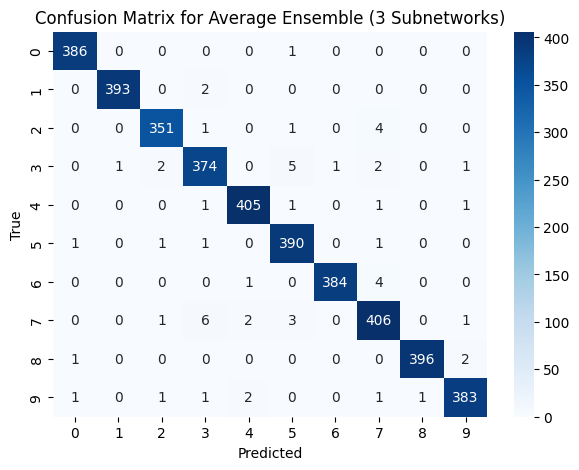

In [ ]:
true_labels = []
predictions_ensemble = []

with torch.no_grad():
   custom_vit.eval()

    c, c1, c2, c3, t = 0, 0, 0, 0, 0
    ece_metric_ensemble = 0.0

    for x, y in DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False):
        x, y = x.to(device), y.to(device)

        # Forward pass for each subnetwork
        logits_1 = custom_vit(x, 0)[:, :10]
        logits_2 = custom_vit(x, 1)[:, :10]
        logits_3 = custom_vit(x, 2)[:, :10]

        # Ensembling
        ensemble_logits = (logits_1 + logits_2 + logits_3) / 3
        final_predictions = ensemble_logits.argmax(dim=-1)

        # Collect predictions and true labels
        predictions_ensemble.extend(final_predictions.cpu().numpy())
        true_labels.extend(y.cpu().numpy())

        # Accuracy calculations
        c +=  (final_predictions == y).sum().item()
        c1 += (logits_1.argmax(dim=-1) == y).sum().item()
        c2 += (logits_2.argmax(dim=-1) == y).sum().item()
        c3 += (logits_3.argmax(dim=-1) == y).sum().item()

        # ECE calculation
        ensemble_probs = F.softmax(ensemble_logits, dim=-1)
        ece_value_e = multiclass_calibration_error(ensemble_probs, y, num_classes=10, n_bins=15, norm="l1")
        ece_metric_ensemble += ece_value_e.item() * len(x)

        t += len(x)

# Calculate accuracy and ECE
accuracy_ensemble = c / t
ece_ensemble = ece_metric_ensemble / t

print(f"Accuracy for 1: {c1 / t}\nAccuracy for 2: {c2 / t}\nAccuracy for 3: {c3 / t}\n\nAccuracy for the Ensemble: {accuracy_ensemble}")
print(f"ECE for the Ensemble: {ece_ensemble}")

# Convert true labels and predictions to numpy arrays
true_labels = np.array(true_labels)
predictions_ensemble = np.array(predictions_ensemble)

# Calculate precision, recall, F1 score, and confusion matrix
precision_ensemble = precision_score(true_labels, predictions_ensemble, average='macro', zero_division=0)
recall_ensemble = recall_score(true_labels, predictions_ensemble, average='macro', zero_division=0)
f1_ensemble = f1_score(true_labels, predictions_ensemble, average='macro')
cm_ensemble = confusion_matrix(true_labels, predictions_ensemble)

# Print performance metrics
print(f"Ensemble - Precision: {precision_ensemble}, Recall: {recall_ensemble}, F1 Score: {f1_ensemble}")

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Average Ensemble (3 Subnetworks)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


##Tests with Gaussian Noised Input

For this test, the `make_it_noisy` function allows to corrupt the input with Gaussian Noise.

In [ ]:
def make_it_noisy(x, mean=0.0, std=0.1):
    noise = torch.randn_like(x) * std + mean
    return torch.clamp(x + noise, 0, 1)

Again, the example shows the test run for a Custom ViT with 3 subnetworks.
Moreover, it is possible to vary the noise levels.

In [ ]:
noise_mean = 0.0
noise_levels = [0.01, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results = []

for noise_std in noise_levels:
    print(f"\nTesting with noise standard deviation: {noise_std}")

    ece_metric_ensemble_custom_3 = 0.0
    accuracy_custom_3 = 0
    c_custom3, t = 0, 0

    with torch.no_grad():
        custom_vit.eval()

        for x, y in DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False):
            x, y = x.to(device), y.to(device)

            # Adding noise
            noisy_x = make_it_noisy(x, mean=noise_mean, std=noise_std)

            # Custom ensemble 3 subnetworks
            logits3_0 = custom_vit(noisy_x, 0)
            logits3_1 = custom_vit(noisy_x, 1)
            logits3_2 = custom_vit(noisy_x, 2)

            logits3_0 = logits3_0[:, :10]
            logits3_1 = logits3_1[:, :10]
            logits3_2 = logits3_2[:, :10]

            ensemble_logits_custom_3 = (logits3_0 + logits3_1 + logits3_2) / 3
            final_predictions_custom_3 = ensemble_logits_custom_3.argmax(dim=-1)

            # Accuracy
            c_custom3 += (final_predictions_custom_3 == y).sum().item()

            # ECE
            ensemble_probs_custom_3 = F.softmax(ensemble_logits_custom_3, dim=-1)
            ece_value_custom_3 = multiclass_calibration_error(ensemble_probs_custom_3, y, num_classes=10, n_bins=15, norm="l1")
            ece_metric_ensemble_custom_3 += ece_value_custom_3.item() * len(x)

            t += len(x)

        accuracy_custom_3 = c_custom3 / t
        ece_ensemble_custom_3 = ece_metric_ensemble_custom_3 / t

        # Print results
        print(f"Custom Ensemble 3 Accuracy (Noisy Input): {accuracy_custom_3:.4f}")
        print(f"ECE for Custom Ensemble 3: {ece_ensemble_custom_3:.4f}")

        results.append({
            "noise_std": noise_std,
            "accuracy_custom_3": accuracy_custom_3,
            "ece_custom_3": ece_ensemble_custom_3
        })

print("\nSummary of Results:")
for res in results:
    print(f"Noise Std: {res['noise_std']:.2f} | Accuracy: {res['accuracy_custom_3']:.4f} | ECE: {res['ece_custom_3']:.4f}")


##Test with Adversarial attack

In this section, there are many tests run with the library [torchattacks](https://github.com/Harry24k/adversarial-attacks-pytorch).

Again, showed tests are for Custom ViT with 3 subnetworks, wrapped with the dedicated class shown above.

All the parameters for the attacks can be modified to enhance the attack's perturbation.

###FGSM Attack

In [ ]:
BATCH_SIZE=16
custom_ensemble = CustomVitEnsemble_3(custom_vit)

# Initialize attacks
FGSM_attack = torchattacks.FGSM(custom_ensemble, eps=8/255)

results = []

ece_metric_ensemble_custom_3 = 0.0
accuracy_custom_3 =  0
c_custom_3, t = 0, 0

with torch.no_grad():
  custom_vit.eval()

for x, y in DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False):
    x, y = x.to(device), y.to(device)
    x.requires_grad = True

    # Generate adversarial examples using FGSM
    adversarial_input = FGSM_attack(x, y)

    # Test the model
    ensemble_logits_custom_3 = custom_ensemble(adversarial_input)
    ensemble_logits_custom_3 = ensemble_logits_custom_3[:, :10]
    final_predictions_custom_3 = ensemble_logits_custom_3.argmax(dim=-1)

    # Accuracy
    c_custom_3 += (final_predictions_custom_3 == y).sum().item()

    # ECE
    ensemble_probs_custom_3 = F.softmax(ensemble_logits_custom_3, dim=-1)
    ece_value_custom_3 = multiclass_calibration_error(ensemble_probs_custom_3, y, num_classes=10, n_bins=15, norm="l1")
    ece_metric_ensemble_custom_3 += ece_value_custom_3.item() * len(x)


    t += len(x)


accuracy_custom_3 = c_custom_3 / t


ece_ensemble_custom_3 = ece_metric_ensemble_custom_3 / t


# Store results
results.append({
    "accuracy_custom_3": accuracy_custom_3,
    "ece_custom_3": ece_ensemble_custom_3,
})

# Print summary of results
print("Summary of Results for FGSM Attack:")
for res in results:
    print(f"Accuracy: {res['accuracy_custom_3']:.4f}| "f"ECE: {res['ece_custom_3']:.4f}")


###PGD Attack

In [ ]:
BATCH_SIZE = 16
custom_ensemble = CustomVitEnsemble_3(custom_vit)

# Initialize attacks
PGD_attack = torchattacks.PGD(custom_ensemble, eps=1/255, alpha=1/510, steps=5, random_start=False)

# Results
results = []

ece_metric_ensemble_custom_3 = 0.0
accuracy_custom_3, = 0
c_custom_3, t = 0, 0

with torch.no_grad():
    custom_vit.eval()

for x, y in DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False):
    x, y = x.to(device), y.to(device)
    x.requires_grad = True

    # Generate adversarial examples using PGD
    adversarial_input = PGD_attack(x, y)

    # Ensemble
    ensemble_logits_custom_3 = custom_ensemble(adversarial_input)
    ensemble_logits_custom_3 = ensemble_logits_custom_3[:, :10]
    final_predictions_custom_3 = ensemble_logits_custom_3.argmax(dim=-1)
    # Accuracy
    c_custom_3 += (final_predictions_custom_3 == y).sum().item()
    # ECE
    ensemble_probs_custom_3 = F.softmax(ensemble_logits_custom_3, dim=-1)
    ece_value_custom_3 = multiclass_calibration_error(ensemble_probs_custom_3, y, num_classes=10, n_bins=15, norm="l1")
    ece_metric_ensemble_custom_3 += ece_value_custom_3.item() * len(x)

    t += len(x)

accuracy_custom_3 = c_custom_3 / t

ece_ensemble_custom_3 = ece_metric_ensemble_custom_3 / t

# Store results
results.append({
    "accuracy_custom_3": accuracy_custom_3,
    "ece_custom_3": ece_ensemble_custom_3,
})

# Print summary of results
print("Summary of Results for PGD Attack:")
for res in results:
    print(f"Accuracy: {res['accuracy_custom_3']:.4f}| "f"ECE: {res['ece_custom_3']:.4f}")


###Square Attack

In [ ]:
BATCH_SIZE = 16
custom_ensemble = CustomVitEnsemble_3(custom_vit)

# Initialize attacks
Square_attack = torchattacks.Square(custom_ensemble, norm='Linf', eps=4/255, n_queries=50, n_restarts=1, p_init=.8, seed=0, verbose=False, loss='margin', resc_schedule=True)

# Results
results = []

ece_metric_ensemble_custom_3 = 0.0
accuracy_custom_3 = 0
c_custom_3, t = 0, 0

with torch.no_grad():
    custom_vit.eval()

for x, y in DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False):
    x, y = x.to(device), y.to(device)
    x.requires_grad = True

    # Generate adversarial examples using Square attack
    adversarial_input = Square_attack(x, y)

    # Ensemble
    ensemble_logits_custom_3 = custom_ensemble(adversarial_input)
    ensemble_logits_custom_3 = ensemble_logits_custom_3[:, :10]
    final_predictions_custom_3 = ensemble_logits_custom_3.argmax(dim=-1)
    # Accuracy
    c_custom_3 += (final_predictions_custom_3 == y).sum().item()
    # ECE
    ensemble_probs_custom_3 = F.softmax(ensemble_logits_custom_3, dim=-1)
    ece_value_custom_3 = multiclass_calibration_error(ensemble_probs_custom_3, y, num_classes=10, n_bins=15, norm="l1")
    ece_metric_ensemble_custom_3 += ece_value_custom_3.item() * len(x)

    t += len(x)

accuracy_custom_3 = c_custom_3 / t

ece_ensemble_custom_3 = ece_metric_ensemble_custom_3 / t

# Store results
results.append({
    "accuracy_custom_3": accuracy_custom_3,
    "ece_custom_3": ece_ensemble_custom_3,
})

# Print summary of results
print("Summary of Results for Square Attack:")
for res in results:
    print(f"Accuracy: {res['accuracy_custom_3']:.4f}| "f"ECE: {res['ece_custom_3']:.4f}")


###CW Attack

In [ ]:
BATCH_SIZE = 16
custom_ensemble = CustomVitEnsemble_3(custom_vit)

# Initialize attacks
CW_attack = torchattacks.CW(custom_ensemble, c=0.1, steps=5, lr=0.01)

# Results
results = []

ece_metric_ensemble_custom_3 = 0.0
accuracy_custom_3 = 0
c_custom_3, t = 0, 0

with torch.no_grad():
    custom_vit.eval()

for x, y in DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False):
    x, y = x.to(device), y.to(device)
    x.requires_grad = True

    # Generate adversarial examples using CW attack
    adversarial_input = CW_attack(x, y)

    # Ensemble
    ensemble_logits_custom_3 = custom_ensemble(adversarial_input)
    ensemble_logits_custom_3 = ensemble_logits_custom_3[:, :10]
    final_predictions_custom_3 = ensemble_logits_custom_3.argmax(dim=-1)
    # Accuracy
    c_custom_3 += (final_predictions_custom_3 == y).sum().item()
    # ECE
    ensemble_probs_custom_3 = F.softmax(ensemble_logits_custom_3, dim=-1)
    ece_value_custom_3 = multiclass_calibration_error(ensemble_probs_custom_3, y, num_classes=10, n_bins=15, norm="l1")
    ece_metric_ensemble_custom_3 += ece_value_custom_3.item() * len(x)

    t += len(x)

accuracy_custom_3 = c_custom_3 / t

ece_ensemble_custom_3 = ece_metric_ensemble_custom_3 / t

# Store results
results.append({
    "accuracy_custom_3": accuracy_custom_3,
    "ece_custom_3": ece_ensemble_custom_3,
})

# Print summary of results
print("Summary of Results for CW Attack:")
for res in results:
    print(f"Accuracy: {res['accuracy_custom_3']:.4f}| "f"ECE: {res['ece_custom_3']:.4f}")


##Test with OOD

In this section, an OOD analysis is performed thanks to [pytorch-ood](https://github.com/kkirchheim/pytorch-ood) library.

The two detectors used are MaxSoftmax and ODIN.

Again, the examples below are for a Custom ViT with 3 subnetworks wrapped in its dedicated class.

It is possible to not use one of the 11 OOD databases, or change the model analyzed.

###MaxSoftmax

In [ ]:
custom_ensemble = CustomVitEnsemble_3(custom_vit)

results = []

train_dataloader = DataLoader(testset, batch_size=64, shuffle=False)

ood_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])
ood_transform_2 = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
])

ood_dataset_names = [
    "CIFAR-10", "CIFAR-100", "MNIST", "FashionMNIST", "LSUN (Resize)", "LSUN (Crop)",
    "Places365", "Textures", "Tiny ImageNet", "Tiny ImageNet (Crop)", "Tiny ImageNet (Resize)"
]
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
  oodset_1 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ood_transform)
  oodset_2 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=ood_transform)
  oodset_3 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=ood_transform_2)
  oodset_4 = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=ood_transform_2)
  oodset_5 = LSUNResize(root="./data", download=True, transform=ood_transform)
  oodset_6 = LSUNCrop(root="./data", download=True, transform=ood_transform)
  oodset_7 = Places365(root="./data", download=True, transform=ood_transform_2)
  oodset_8 = Textures(root="./data", download=True, transform=ood_transform)
  oodset_9 = TinyImageNet(root="./data", download=True, transform=ood_transform_2)
  oodset_10 = TinyImageNetCrop(root="./data", download=True, transform=ood_transform)
  oodset_11 = TinyImageNetResize(root="./data", download=True, transform=ood_transform)

oodloaders = [
    DataLoader(oodset_1, batch_size=64, shuffle=False),
    DataLoader(oodset_2, batch_size=64, shuffle=False),
    DataLoader(oodset_3, batch_size=64, shuffle=False),
    DataLoader(oodset_4, batch_size=64, shuffle=False),
    DataLoader(oodset_5, batch_size=64, shuffle=False),
    DataLoader(oodset_6, batch_size=64, shuffle=False),
    DataLoader(oodset_7, batch_size=64, shuffle=False),
    DataLoader(oodset_8, batch_size=64, shuffle=False),
    DataLoader(oodset_9, batch_size=64, shuffle=False),
    DataLoader(oodset_10, batch_size=64, shuffle=False),
    DataLoader(oodset_11, batch_size=64, shuffle=False)
]

custom_ensemble.eval()
print("Printing OOD metrics for Custom Ensemble with 3 subnetworks:")

for dataset_name, oodloader in zip(ood_dataset_names, oodloaders):
  with torch.no_grad():

    print(f"Testing OOD metrics for {dataset_name}")
    detector = MaxSoftmax(model=custom_ensemble)
    detector.fit(train_dataloader, device=device)

    all_x = []
    all_y = []

    for batch in DataLoader(testset, batch_size=64):
        x, y = batch

        x = x.to(device)
        x = detector(x)

        all_x.append(x.cpu().numpy())
        all_y.extend([0] * len(x))

    for batch in oodloader:
        x, y = batch

        x = x.to(device)
        x = detector(x)

        all_x.append(x.cpu().numpy())
        all_y.extend([-1] * len(x))

    all_y = np.asarray(all_y)
    all_x = np.concatenate(all_x)

    metric = OODMetrics()

    metric.update(torch.tensor(all_x).squeeze(), torch.tensor(all_y).squeeze())
    r = {"Dataset": dataset_name}

    r.update(metric.compute())
    results.append(r)

df_custom_ensemble_MaxSoftmax = pd.DataFrame(results)
print(tabulate(df_custom_ensemble_MaxSoftmax, headers='keys', tablefmt='grid', showindex=False))
df_custom_ensemble_MaxSoftmax.to_csv('df_custom_ensemble_3_MaxSoftmax.csv', index=False)


###ODIN

In [ ]:
train_dataloader = DataLoader(testset, batch_size=64, shuffle=False)

custom_ensemble = CustomVitEnsemble_3(custom_vit)

results = []

ood_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])
ood_transform_2 = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
])

ood_dataset_names = [
    "CIFAR-10", "CIFAR-100", "MNIST", "FashionMNIST", "LSUN (Resize)", "LSUN (Crop)",
    "Places365", "Textures", "Tiny ImageNet", "Tiny ImageNet (Crop)", "Tiny ImageNet (Resize)"
]

dataset_configs = {
    "CIFAR-10": {"norm_std": 0.01, "eps": 0.002},
    "CIFAR-100": {"norm_std": 0.01, "eps": 0.002},
    "MNIST": {"norm_std": 0.05, "eps": 0.005},
    "FashionMNIST": {"norm_std": 0.05, "eps": 0.005},
    "LSUN (Resize)": {"norm_std": 0.05, "eps": 0.01},
    "LSUN (Crop)": {"norm_std": 0.05, "eps": 0.01},
    "Places365": {"norm_std": 0.05, "eps": 0.01},
    "Textures": {"norm_std": 0.05, "eps": 0.01},
    "Tiny ImageNet": {"norm_std": 0.05, "eps": 0.005},
    "Tiny ImageNet (Crop)": {"norm_std": 0.05, "eps": 0.005},
    "Tiny ImageNet (Resize)": {"norm_std": 0.05, "eps": 0.005},
}

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
  oodset_1 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ood_transform)
  oodset_2 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=ood_transform)
  oodset_3 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=ood_transform_2)
  oodset_4 = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=ood_transform_2)
  oodset_5 = LSUNResize(root="./data", download=True, transform=ood_transform)
  oodset_6 = LSUNCrop(root="./data", download=True, transform=ood_transform)
  oodset_7 = Places365(root="./data", download=True, transform=ood_transform_2)
  oodset_8 = Textures(root="./data", download=True, transform=ood_transform)
  oodset_9 = TinyImageNet(root="./data", download=True, transform=ood_transform_2)
  oodset_10 = TinyImageNetCrop(root="./data", download=True, transform=ood_transform)
  oodset_11 = TinyImageNetResize(root="./data", download=True, transform=ood_transform)

oodloaders = [
    DataLoader(oodset_1, batch_size=64, shuffle=False),
    DataLoader(oodset_2, batch_size=64, shuffle=False),
    DataLoader(oodset_3, batch_size=64, shuffle=False),
    DataLoader(oodset_4, batch_size=64, shuffle=False),
    DataLoader(oodset_5, batch_size=64, shuffle=False),
    DataLoader(oodset_6, batch_size=64, shuffle=False),
    DataLoader(oodset_7, batch_size=64, shuffle=False),
    DataLoader(oodset_8, batch_size=64, shuffle=False),
    DataLoader(oodset_9, batch_size=64, shuffle=False),
    DataLoader(oodset_10, batch_size=64, shuffle=False),
    DataLoader(oodset_11, batch_size=64, shuffle=False)
]

custom_ensemble.eval()

for dataset_name, oodloader in zip(ood_dataset_names, oodloaders):
  with torch.no_grad():

    norm_std = dataset_configs[dataset_name]["norm_std"]
    eps = dataset_configs[dataset_name]["eps"]
    print(f"Testing OOD metrics for {dataset_name} (norm_std: {norm_std}, eps: {eps})")

    detector = ODIN(custom_ensemble,norm_std=torch.tensor([norm_std]), eps=eps)
    detector.fit(train_dataloader, device=device)

    all_x = []
    all_y = []

    for batch in DataLoader(testset, batch_size=64):
        x, y = batch

        x = x.to(device)
        x = detector(x)

        all_x.append(x.cpu().numpy())
        all_y.extend([0] * len(x))

    for batch in oodloader:
        x, y = batch

        x = x.to(device)
        x = detector(x)

        all_x.append(x.cpu().numpy())
        all_y.extend([-1] * len(x))

    all_y = np.asarray(all_y)
    all_x = np.concatenate(all_x)

    metric = OODMetrics()
    metric.update(torch.tensor(all_x).squeeze(), torch.tensor(all_y).squeeze())

    r = {"Dataset": dataset_name,"Std": norm_std,"eps":eps}

    r.update(metric.compute())
    results.append(r)

df_custom_ensemble_ODIN = pd.DataFrame(results)
print(tabulate(df_custom_ensemble_ODIN, headers='keys', tablefmt='grid', showindex=False))
df_custom_ensemble_ODIN.to_csv('df_custom_ensemble_3_ODIN.csv', index=False)